In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import lines as mlines
import os
from astropy.table import Table

In [2]:
from read_sfh import get_scales
small_file_fname = "/Users/aphearin/Dropbox/UniverseMachine/data/histories/small_sfh_catalog_1.002310.txt"
scale_factor_array = get_scales(small_file_fname)
cosmic_age_array = np.load('/Users/aphearin/Dropbox/UniverseMachine/data/histories/prelim_sfh_reduction/times.npy')

In [3]:
from collate_full_catalog import collate_catalog
a_string = 'a_1.002310'
idx_tobs = np.where(scale_factor_array >= float(a_string[2:]))[0][0]
t_today = cosmic_age_array[idx_tobs]

history_colnames = ('halo_id', 'halo_upid', 'halo_mpeak', 'halo_vmax_at_mpeak', 
                'stellar_mass', 'sfr', 'a_first_infall')
halocat_propnames = ('x', 'y', 'z', 'rvir')
histories = collate_catalog(a_string, history_colnames=history_colnames, 
                            halocat_propnames=halocat_propnames, verbose=True)
print("Number of galaxies = {0}".format(len(histories)))

... Assembling history data
... Assembling halo catalog data
... Cross-matching on halo_id

Number of objects in history catalog = 676028
Number of objects in halo catalog = 12085858
Number of matching objects = 640466
Fraction of objects appearing in both catalogs = 0.947
New colnames to add from halo catalog = ['y', 'x', 'z', 'rvir']

Number of galaxies = 676028


In [4]:
histories['ssfr'] = np.log10(histories['sfr']/histories['stellar_mass'])

## Cluster profile dependence on $M_*$

In [5]:
from halotools.mock_observables import return_xyz_formatted_array, radial_profile_3d

In [6]:
cluster_mask = (histories['halo_mpeak'] > 1e14) & (histories['gal_type'] == 'central')

cluster_pos = return_xyz_formatted_array(histories['x'], histories['y'], histories['z'], 
                                         mask=cluster_mask, period=250)
clusters = histories[cluster_mask]

In [7]:
sm_low, sm_high = 10, 10.25
sm_mask = (np.log10(histories['stellar_mass']) > sm_low) & (np.log10(histories['stellar_mass']) < sm_high)
sample_pos = return_xyz_formatted_array(histories['x'], histories['y'], histories['z'], 
                                         mask=sm_mask, period=250.0)
sample = histories[sm_mask]

In [8]:
sm_low, sm_high = 10.5, 10.75
sm_mask2 = (np.log10(histories['stellar_mass']) > sm_low) & (np.log10(histories['stellar_mass']) < sm_high)
sample2_pos = return_xyz_formatted_array(histories['x'], histories['y'], histories['z'], 
                                         mask=sm_mask2, period=250.0)
sample2 = histories[sm_mask2]

In [9]:
sm_low, sm_high = 9, 9.25
sm_mask3 = (np.log10(histories['stellar_mass']) > sm_low) & (np.log10(histories['stellar_mass']) < sm_high)
sample3_pos = return_xyz_formatted_array(histories['x'], histories['y'], histories['z'], 
                                         mask=sm_mask3, period=250.0)
sample3 = histories[sm_mask3]

In [10]:
rbins_normalized = np.linspace(0.25, 25, 20)
rbins_normalized_midpoints = (rbins_normalized[:-1] + rbins_normalized[1:])/2.

cluster_result = radial_profile_3d(cluster_pos, sample_pos, sample['ssfr'],
                           rbins_normalized = rbins_normalized,
                           normalize_rbins_by = clusters['rvir']/1000.,
                           period=250)

cluster_result2 = radial_profile_3d(cluster_pos, sample2_pos, sample2['ssfr'],
                           rbins_normalized = rbins_normalized,
                           normalize_rbins_by = clusters['rvir']/1000.,
                           period=250)

cluster_result3 = radial_profile_3d(cluster_pos, sample3_pos, sample3['ssfr'],
                           rbins_normalized = rbins_normalized,
                           normalize_rbins_by = clusters['rvir']/1000.,
                           period=250)


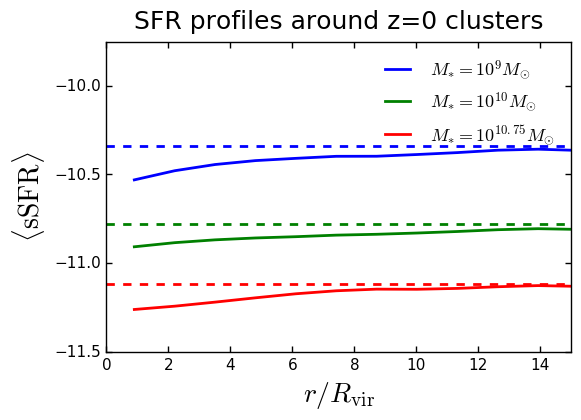

In [11]:
from scipy.signal import savgol_filter, medfilt

fig = plt.figure()
ax = fig.add_subplot(111)

y3 = medfilt(cluster_result3, 3)
y3 = savgol_filter(y3, 9, 3)
ax.plot(rbins_normalized_midpoints, y3, 
        color='blue', linewidth=2, label=r'$M_{\ast} = 10^{9}M_{\odot}$')
mean_sample3_ssfr = np.mean(sample3['ssfr'])
ax.plot(np.arange(100), np.zeros(100) + mean_sample3_ssfr, ls='--', color='blue', linewidth=2)

y = medfilt(cluster_result, 3)
y = savgol_filter(y, 9, 3)
ax.plot(rbins_normalized_midpoints, y, 
        color='green', linewidth=2, label=r'$M_{\ast} = 10^{10}M_{\odot}$')
mean_sample_ssfr = np.mean(sample['ssfr'])
ax.plot(np.arange(100), np.zeros(100) + mean_sample_ssfr, ls='--', color='green', linewidth=2)

y2 = medfilt(cluster_result2, 3)
y2 = savgol_filter(y2, 9, 3)
ax.plot(rbins_normalized_midpoints, y2, 
        color='red', linewidth=2, label=r'$M_{\ast} = 10^{10.75}M_{\odot}$')
mean_sample2_ssfr = np.mean(sample2['ssfr'])
ax.plot(np.arange(100), np.zeros(100) + mean_sample2_ssfr, ls='--', color='red', linewidth=2)


xlabel = ax.set_xlabel(r'$r / R_{\rm vir}$', fontsize=20)
ylabel = ax.set_ylabel(r'$\langle{\rm sSFR}\rangle$', fontsize=20)
title = ax.set_title(r'SFR profiles around z=0 clusters', 
                     fontsize=18, y=1.02) 

plt.xlabel(r'$r / R_{\rm vir}$', size=20)
plt.ylabel(r'$\langle{\rm sSFR}\rangle$', size=20)
plt.xticks(fontsize=17); plt.yticks(fontsize=17)
plt.xlim(xmin = 0., xmax=15)
plt.ylim(ymin = -11.5, ymax = -9.75)

plt.legend(loc='upper right', fontsize=13)

ax.tick_params(axis='x', length=4, width=1, which='major')
ax.tick_params(axis='x', length=2, width=1, which='minor')
ax.tick_params(axis='y', length=4, width=1, which='major')
ax.tick_params(axis='y', length=2, width=1, which='minor')
plt.xticks(fontsize=11); plt.yticks(fontsize=11)

fig.savefig('FIGS/cluster_profiles_sm_dependence.pdf', 
            bbox_extra_artists=[xlabel, ylabel], bbox_inches='tight')

## Cluster profile dependence on galaxy type

In [57]:
sm_low, sm_high = 9, 9.25
sm_mask = (np.log10(histories['stellar_mass']) > sm_low) & (np.log10(histories['stellar_mass']) < sm_high)
host_mask = sm_mask * (histories['gal_type'] == 'central')
sat_mask = sm_mask * ((histories['gal_type'] == 'satellite') | (histories['gal_type'] == 'orphan'))
cen_mask = sm_mask * ((histories['gal_type'] == 'central') | (histories['gal_type'] == 'backsplash'))
sp_mask = sm_mask * (histories['gal_type'] == 'backsplash')

In [58]:
sample_pos = return_xyz_formatted_array(histories['x'], histories['y'], histories['z'], 
                                         mask=sm_mask, period=250.0)

host_pos = return_xyz_formatted_array(histories['x'], histories['y'], histories['z'], 
                                         mask=host_mask, period=250.0)

sat_pos = return_xyz_formatted_array(histories['x'], histories['y'], histories['z'], 
                                         mask=sat_mask, period=250.0)

cen_pos = return_xyz_formatted_array(histories['x'], histories['y'], histories['z'], 
                                         mask=cen_mask, period=250.0)

sp_pos = return_xyz_formatted_array(histories['x'], histories['y'], histories['z'], 
                                         mask=sp_mask, period=250.0)

In [59]:
sample = histories[sm_mask]
hosts = histories[host_mask]
sats = histories[sat_mask]
cens = histories[cen_mask]
sps = histories[sp_mask]
print(len(sample), len(hosts), len(sats), len(cens), len(sps))

(150958, 84668, 53303, 97655, 12987)


In [60]:
rbins_normalized = np.linspace(0.25, 25, 20)
rbins_normalized_midpoints = (rbins_normalized[:-1] + rbins_normalized[1:])/2.

sample_result = radial_profile_3d(cluster_pos, sample_pos, sample['ssfr'],
                           rbins_normalized = rbins_normalized,
                           normalize_rbins_by = clusters['rvir']/1000., period=250)

hosts_result = radial_profile_3d(cluster_pos, host_pos, hosts['ssfr'],
                           rbins_normalized = rbins_normalized,
                           normalize_rbins_by = clusters['rvir']/1000., period=250)

sat_result = radial_profile_3d(cluster_pos, sat_pos, sats['ssfr'],
                           rbins_normalized = rbins_normalized,
                           normalize_rbins_by = clusters['rvir']/1000., period=250)

cen_result = radial_profile_3d(cluster_pos, cen_pos, cens['ssfr'],
                           rbins_normalized = rbins_normalized,
                           normalize_rbins_by = clusters['rvir']/1000., period=250)

sp_result = radial_profile_3d(cluster_pos, sp_pos, sps['ssfr'],
                           rbins_normalized = rbins_normalized,
                           normalize_rbins_by = clusters['rvir']/1000., period=250)

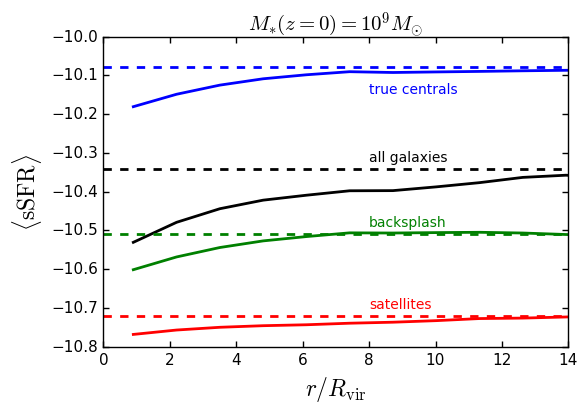

In [131]:
from scipy.signal import savgol_filter, medfilt

fig = plt.figure()
ax = fig.add_subplot(111)

y1 = medfilt(sample_result, 3)
y1 = savgol_filter(y1, 9, 3)
ax.plot(rbins_normalized_midpoints, y1, color='k', linewidth=2, label='all galaxies')
mean_sample_ssfr = np.mean(sample['ssfr'])
ax.plot(np.arange(100), np.zeros(100) + mean_sample_ssfr, ls='--', color='k', linewidth=2)

y2 = medfilt(hosts_result, 3)
y2 = savgol_filter(y2, 9, 3)
ax.plot(rbins_normalized_midpoints, y2, color='blue', linewidth=2, label=r'true centrals')
mean_hosts_ssfr = np.mean(hosts['ssfr'])
ax.plot(np.arange(100), np.zeros(100) + mean_hosts_ssfr, ls='--', color='blue', linewidth=2)

y3 = medfilt(sat_result, 3)
y3 = savgol_filter(y3, 9, 3)
ax.plot(rbins_normalized_midpoints, y3, color='red', linewidth=2, label='satellites')
mean_sats_ssfr = np.mean(sats['ssfr'])
ax.plot(np.arange(100), np.zeros(100) + mean_sats_ssfr, ls='--', color='red', linewidth=2)

y4 = medfilt(sp_result, 3)
y4 = savgol_filter(y4, 9, 3)
ax.plot(rbins_normalized_midpoints, y4, color='green', linewidth=2, label='backsplash')
mean_sps_ssfr = np.mean(sps['ssfr'])
ax.plot(np.arange(100), np.zeros(100) + mean_sps_ssfr, ls='--', color='green', linewidth=2)

xlabel = ax.set_xlabel(r'$r / R_{\rm vir}$', fontsize=16)
ylabel = ax.set_ylabel(r'$\langle{\rm sSFR}\rangle$', fontsize=16)
title = ax.set_title(r'$M_{\ast}(z=0) = 10^{9}M_{\odot}$', fontsize=15, y=1) 

plt.xlabel(r'$r / R_{\rm vir}$', size=17)
plt.ylabel(r'$\langle{\rm sSFR}\rangle$', size=17)
plt.xticks(fontsize=11); plt.yticks(fontsize=11)
plt.xlim(xmin = 0., xmax=14)
plt.ylim(ymin = -10.8, ymax = -10)

ax.annotate('true centrals', xytext=(8, mean_hosts_ssfr-0.07), xy=(5, -10.5), color='blue')
ax.annotate('all galaxies', xytext=(8, mean_sample_ssfr+0.02), xy=(5, -10.5), color='k')
ax.annotate('satellites', xytext=(8, mean_sats_ssfr + 0.02), xy=(5, -10.5), color='red')
ax.annotate('backsplash', xytext=(8, mean_sps_ssfr + 0.02), xy=(5, -10.5), color='green')

fig.savefig('FIGS/cluster_profiles_gal_type_decomposition.pdf', 
            bbox_extra_artists=[xlabel, ylabel], bbox_inches='tight')

## Galaxy type fraction profiles

In [126]:
frac_true_cen_profile = radial_profile_3d(cluster_pos, sample_pos, sample['gal_type']=='central',
                           rbins_normalized = rbins_normalized,
                           normalize_rbins_by = clusters['rvir']/1000., period=250)

frac_backsplash_profile = radial_profile_3d(cluster_pos, sample_pos, sample['gal_type']=='backsplash',
                           rbins_normalized = rbins_normalized,
                           normalize_rbins_by = clusters['rvir']/1000., period=250)

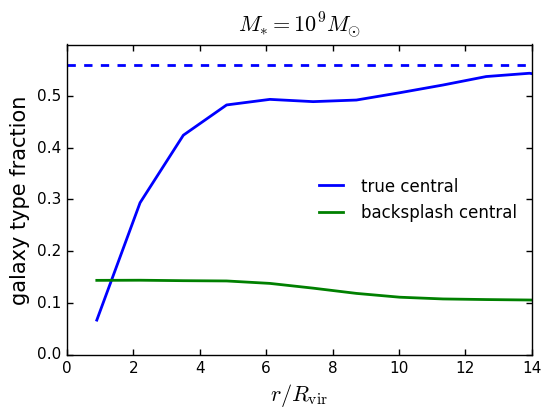

In [157]:
from scipy.signal import savgol_filter, medfilt

fig = plt.figure()
ax = fig.add_subplot(111)

y1 = medfilt(frac_true_cen_profile, 3)
y1 = savgol_filter(y1, 9, 3)
ax.plot(rbins_normalized_midpoints, y1, 
        color='blue', linewidth=2, label='true central')
ax.plot(np.arange(100), np.zeros(100) + np.mean(sample['gal_type'] == 'central'), 
        ls='--', color='blue', linewidth=2)

y2 = medfilt(frac_backsplash_profile, 5)
y2 = savgol_filter(y2, 17, 9)
ax.plot(rbins_normalized_midpoints, y2, 
        color='green', linewidth=2, label='backsplash central')

xlabel = ax.set_xlabel(r'$r / R_{\rm vir}$', size=16)
ylabel = ax.set_ylabel(r'galaxy type fraction', size=15)
title = ax.set_title(r'$M_{\ast} = 10^{9}M_{\odot}$', fontsize=16, y=1.02) 

plt.xticks(fontsize=11); plt.yticks(fontsize=11)
plt.xlim(xmin = 0., xmax=14)
plt.ylim(ymin = 0, ymax = 0.6)

plt.legend(loc='best', fontsize=12)

fig.savefig('FIGS/cluster_gal_type_profiles.pdf', 
            bbox_extra_artists=[xlabel, ylabel], bbox_inches='tight')